In [1]:
using JuMP
using Gurobi
using MosekTools
using ECOS
using LinearAlgebra
using Plots
const GRB_ENV = Gurobi.Env();

┌ Info: Recompiling stale cache file C:\Users\johan\.julia\compiled\v1.2\Plots\ld3vC.ji for Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1240


Academic license - for non-commercial use only


In [2]:
n = 85
σ_ij = zeros(n, n);

## JE Beasley's OR library

In [3]:
lines = readlines("port2.txt");

In [4]:
df1 = [map(x->parse(Float64,x), split(line, " ")[2:end])
    for line in lines[2:86]];
m, stdiv =getindex.(df1,1),getindex.(df1,2);

In [5]:
for line in lines[87:end-1]
    i, j, s = map(x->parse(Float64,x), split(line, " ")[2:end])
    i, j = Int(i), Int(j)
    sigma = s*stdiv[i]*stdiv[j]
    σ_ij[i, j] = sigma
    σ_ij[j, i] = sigma
end

In [28]:
minimum(m), maximum(m)

(-0.004002, 0.009794)

## Bloomberg data

In [21]:
using CSV

df = CSV.read("StockReturnsTestSampleContinuous.csv");
mat = convert(Matrix, df[:,2:end]);
using Statistics
σ_ij2 = cov(mat)
μ = mean(mat, dims=1);

## Quadratic model

In [6]:
finmodel = Model(with_optimizer(Gurobi.Optimizer, GRB_ENV, OutputFlag=0))
@variable(finmodel, x[1:85]>=0);
@variable(finmodel, ρ)
@constraint(finmodel, sum(x)==1)
@constraint(finmodel, dot(m,x) == ρ);
@objective(finmodel, Min, x'*σ_ij*x);

In [7]:
vals = []
for c in range(0.1,stop=10,length=30)
    ρ_i = c*0.0009248
    fix(ρ, ρ_i)
    optimize!(finmodel)
    push!(vals, [objective_value(finmodel), ρ_i])
end

In [8]:
xy = hcat(vals...)'
x1,y1  = xy[:,1], xy[:,2];

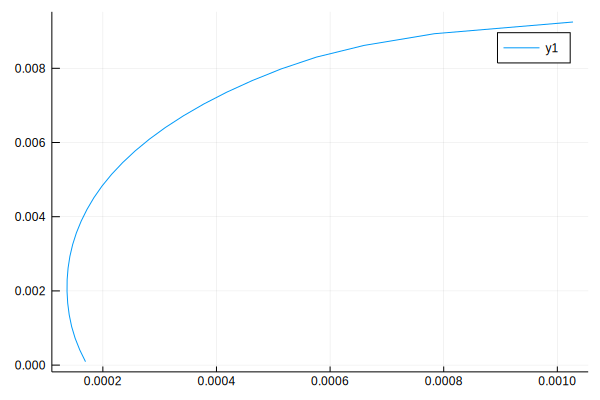

In [9]:
plot(x1,y1)

## Robust code

In [10]:
robmodel = Model(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(robmodel, x[1:85]>=0)
@variable(robmodel, z[1:85]>=0)
@variable(robmodel, t>=0)
@variable(robmodel, ρ)
@objective(robmodel, Min, dot(m, x))
@constraint(robmodel, sum(x)==1)
@constraint(robmodel, sqrt(σ_ij)*x .== z)
@constraint(robmodel, [t; z] in SecondOrderCone())
@constraint(robmodel, dot(m, x)+t>=ρ);

In [11]:
vals2 = []
for c in range(0.1,stop=10,length=30)
    ρ_i = c*0.0009248
    fix(ρ, ρ_i)
    optimize!(robmodel)
    objv = objective_value(robmodel)
    σ = value.(x)'*σ_ij*value.(x)
    push!(vals2, [σ, ρ_i])
end

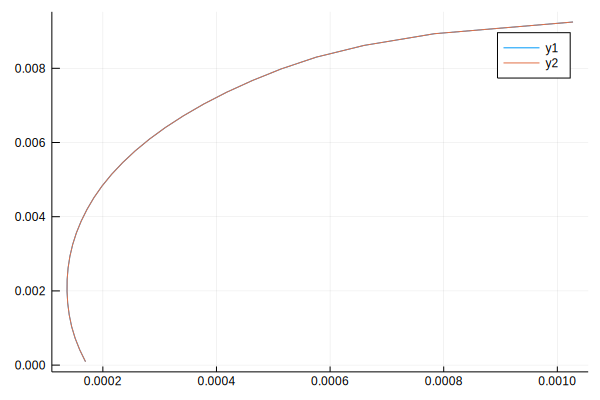

In [12]:
xy2 = hcat(vals...)'
x2,y2  = xy2[:,1], xy2[:,2];
plot(x2,y2)
plot!(x1,y1)

## Code from class

In [4]:
a = [120, 100, 180, 140]
b = 5000

5000

In [35]:
E = diagm(0=>a)*0.3
robmodel = Model(with_optimizer(Mosek.Optimizer, QUIET=true))
@variable(robmodel, x[1:4]>=0)
@variable(robmodel, z[1:4]>=0)
@variable(robmodel, t>=0)
@objective(robmodel, Max, 50*x[1]+40*x[2]+60*x[3]+30*x[4])
@constraint(robmodel, 2*x[1]+3*x[2]+6*x[3]+1*x[4] <= 80)
@constraint(robmodel, 3*x[1]+2*x[2]+2*x[3]+0*x[4] <= 40)
#@constraint(robmodel, b - dot(a, x) == t)
@constraint(robmodel, sqrt(E)*x .== z)
@constraint(robmodel, [t; z] in SecondOrderCone())
#@constraint(robmodel, dot(z, z) <= t^2)
@constraint(robmodel, dot(a, x)+t==b)
optimize!(robmodel)

In [36]:
value.(x)

4-element Array{Float64,1}:
  4.238764816275562 
  9.827448851817634 
  3.8144037981457344
 19.153700451494757 

In [23]:
value.(t)

140.49668848980707

In [3]:
model = Model(with_optimizer(Gurobi.Optimizer, OutputFlag=0))
@variable(model, x[1:4]>=0)

# objective
profit = 50*x[1]+40*x[2]+60*x[3]+30*x[4]

@constraint(model, dot(a, x)<=b)
@constraint(model, 2*x[1]+3*x[2]+6*x[3]+1*x[4] <= 80)
@constraint(model, 3*x[1]+2*x[2]+2*x[3]+0*x[4] <= 40)
@objective(model, Max, profit)
optimize!(model)

Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [7]:
E = diagm(0=>a)*0.3

function wc_val(a, E, x)
    return a+E*x/sqrt(dot(x, E*x))
end

wc_val (generic function with 1 method)

In [14]:
for k in 1:20
    xk=value.(x)
    a_wc = wc_val(a, E, xk)
    @constraint(model, dot(a_wc, x)<=b)
    optimize!(model)
    println("Relaxed Solution (iteration " * string(k) *") : "* string(value.(x))) 
end

Relaxed Solution (iteration 1) : [4.806467620983567, 8.479879529227865, 4.310419039296784, 19.084911934568566]
Relaxed Solution (iteration 2) : [2.903641587353474, 13.074365855810676, 2.570171763159112, 19.548588678906352]
Relaxed Solution (iteration 3) : [3.8798053233817904, 10.700977705674592, 3.479314309252722, 19.261570380696313]
Relaxed Solution (iteration 4) : [4.3431478337057925, 9.574433476597232, 3.9108447728440776, 19.125335265732254]
Relaxed Solution (iteration 5) : [4.112873310357753, 10.133276506140774, 3.697413528322595, 19.189942690926596]
Relaxed Solution (iteration 6) : [4.2283270773853765, 9.85282967097478, 3.804679712947155, 19.15677855462198]
Relaxed Solution (iteration 7) : [4.285746766271372, 9.713352454779306, 3.858027395813634, 19.140284728237532]
Relaxed Solution (iteration 8) : [4.257056468614461, 9.783027506931512, 3.8313877901467945, 19.148477801095773]
Relaxed Solution (iteration 9) : [4.242692633073417, 9.81791041412181, 3.8180506362680653, 19.152579673879